<a href="https://colab.research.google.com/github/njpinton/CMSC178IP/blob/main/Image_Representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

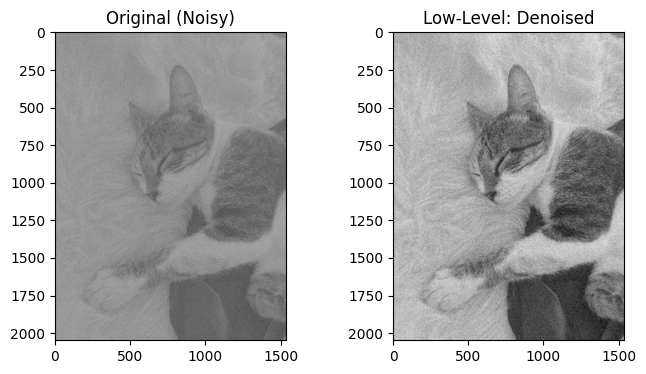

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale image
image_path = '/content/drive/MyDrive/up cebu/csmc 178IP/data/anya0.jpg'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Rescale image
norm_factor = 255.
img = img.astype('float32')/norm_factor

noise_factor = 0.25
img_noisy = img + noise_factor * np.random.randn(*img.shape)

# Gaussian filter for denoising
denoised = cv2.GaussianBlur(img_noisy, (5, 5), sigmaX=1.5)

# Display
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img_noisy, cmap='gray'); plt.title("Original (Noisy)")
plt.subplot(1,2,2); plt.imshow(denoised, cmap='gray'); plt.title("Low-Level: Denoised")
plt.show()


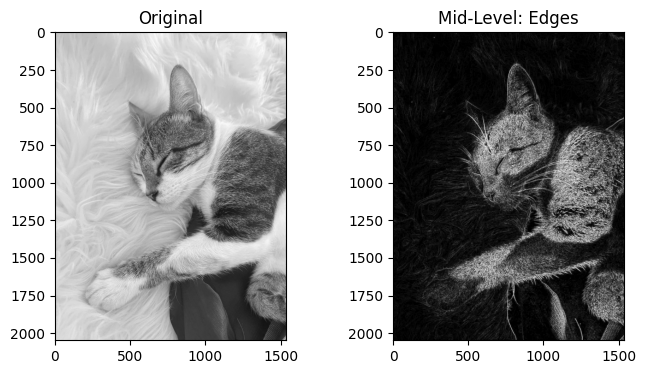

In [2]:
# Load grayscale image
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Sobel operator
grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
magnitude = cv2.magnitude(grad_x, grad_y)

# Normalize for display
magnitude = cv2.convertScaleAbs(magnitude)

# Display
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(magnitude, cmap='gray'); plt.title("Mid-Level: Edges")
plt.show()


In [4]:
import torch
import torchvision.transforms as T
from torchvision import models
from PIL import Image
import requests

# Load pretrained model
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
model.eval()

# Image preprocessing
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Load image
img = Image.open(image_path).convert("RGB")
x = transform(img).unsqueeze(0)  # batch size 1

# Forward pass
with torch.no_grad():
    logits = model(x)
    probs = torch.nn.functional.softmax(logits, dim=1)

# Top-5 predictions
labels = models.MobileNet_V2_Weights.IMAGENET1K_V1.meta["categories"]
top5 = torch.topk(probs, 5)
for idx, score in zip(top5.indices[0], top5.values[0]):
    print(f"{labels[idx]}: {score.item()*100:.2f}%")


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 176MB/s]


tabby: 38.42%
tiger cat: 28.71%
Egyptian cat: 13.06%
plastic bag: 9.16%
paper towel: 2.03%


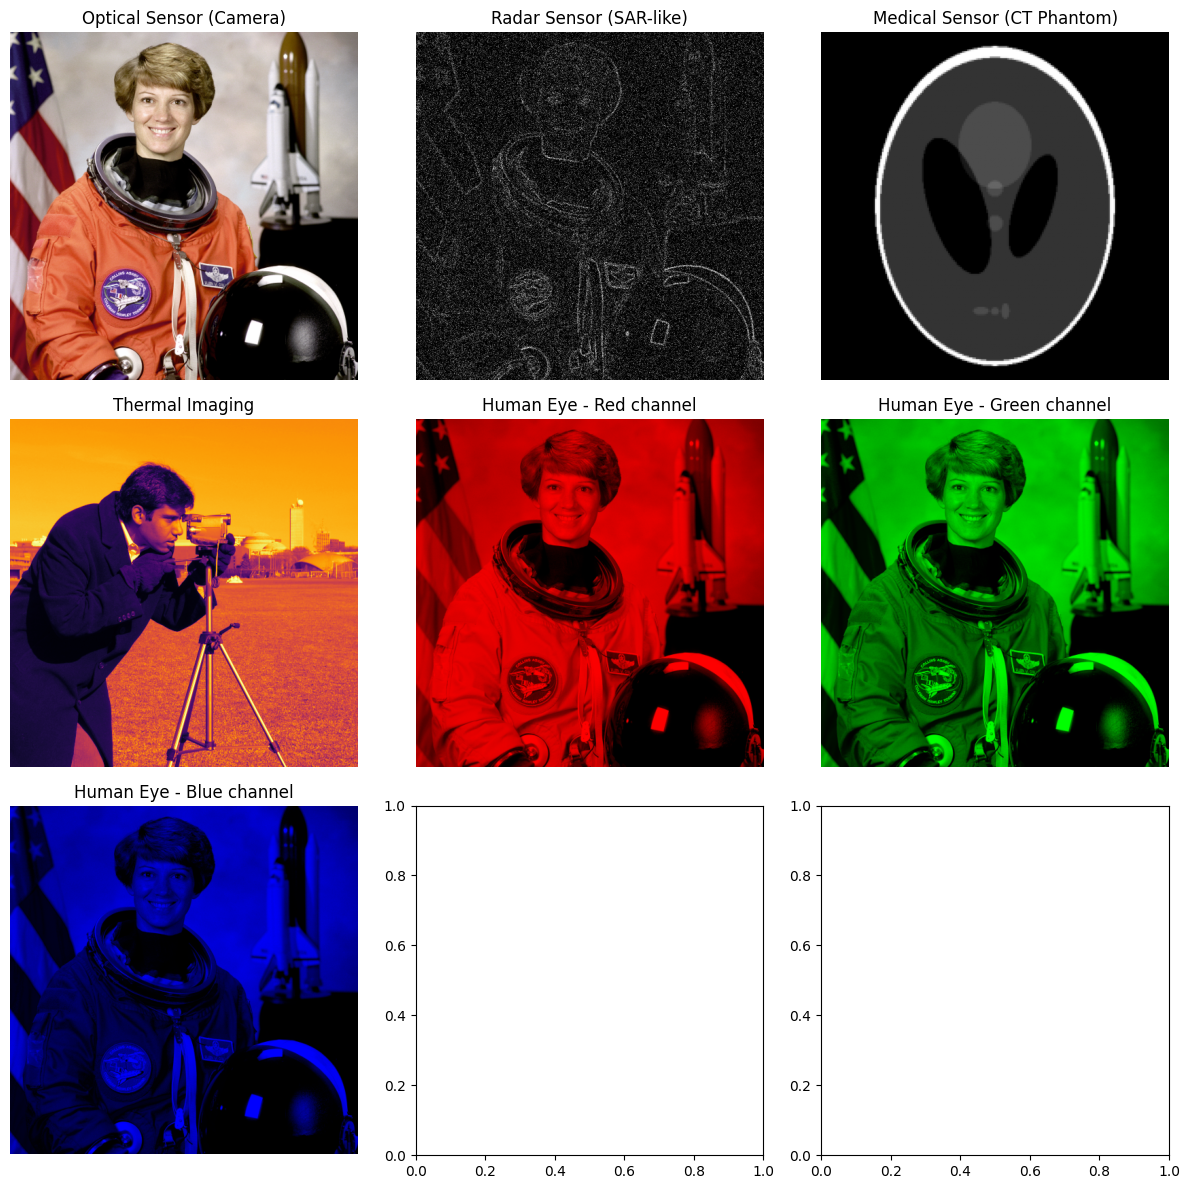

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, filters, exposure
from skimage.transform import rescale
import cv2

# 1. Optical Sensor (normal RGB photo)
optical_img = data.astronaut()

# 2. Radar Sensor (simulate with edge + speckle noise)
radar_base = color.rgb2gray(data.astronaut())
radar_edges = filters.sobel(radar_base)
speckle = radar_edges + 0.2 * np.random.randn(*radar_edges.shape)
speckle = np.clip(speckle, 0, 1)

# 3. Medical Sensor (CT slice from skimage)
ct_img = data.shepp_logan_phantom()
ct_img = rescale(ct_img, 0.5, anti_aliasing=True)

# 4. Other Sensors (thermal image simulation)
thermal_base = data.camera().astype(float)
thermal_norm = (thermal_base - thermal_base.min()) / (thermal_base.max() - thermal_base.min())
thermal_img = plt.cm.inferno(thermal_norm)

# 5. Human Eye (simulate rods/cones with RGB separation)
eye_img = data.astronaut()
channels = ["Red", "Green", "Blue"]
eye_channels = []
for i in range(3):
    ch_img = np.zeros_like(eye_img)
    ch_img[:,:,i] = eye_img[:,:,i]
    eye_channels.append(ch_img)

# ---- Display in subplots ----
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Optical
axs[0,0].imshow(optical_img)
axs[0,0].set_title("Optical Sensor (Camera)")
axs[0,0].axis("off")

# Radar
axs[0,1].imshow(speckle, cmap="gray")
axs[0,1].set_title("Radar Sensor (SAR-like)")
axs[0,1].axis("off")

# Medical
axs[0,2].imshow(ct_img, cmap="gray")
axs[0,2].set_title("Medical Sensor (CT Phantom)")
axs[0,2].axis("off")

# Thermal
axs[1,0].imshow(thermal_img)
axs[1,0].set_title("Thermal Imaging")
axs[1,0].axis("off")

# Human Eye channels
for i, ch in enumerate(eye_channels):
    r, c = divmod(i+1, 3)
    axs[r+1, c].imshow(ch)
    axs[r+1, c].set_title(f"Human Eye - {channels[i]} channel")
    axs[r+1, c].axis("off")

# Hide unused axes
axs[1,1].axis("off")
axs[1,2].axis("off")

plt.tight_layout()
plt.show()


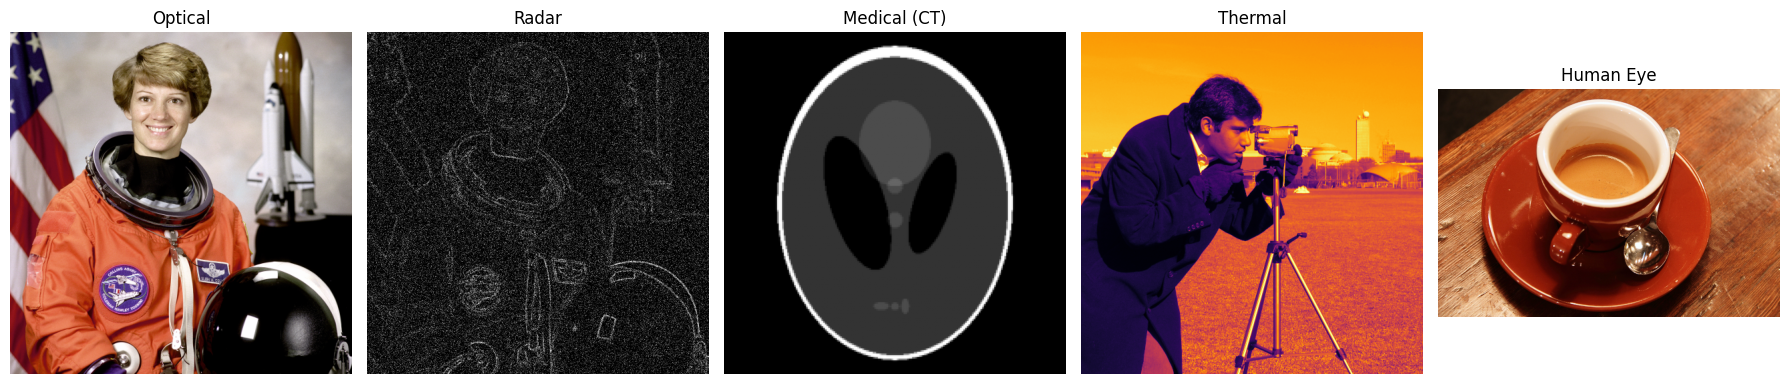

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, filters
from skimage.transform import rescale

# --- Generate example images for each sensor type ---

# Optical Sensor (RGB photo)
optical_img = data.astronaut()

# Radar Sensor (edge + speckle noise simulation)
radar_base = color.rgb2gray(optical_img)
radar_edges = filters.sobel(radar_base)
speckle = radar_edges + 0.2 * np.random.randn(*radar_edges.shape)
speckle = np.clip(speckle, 0, 1)

# Medical Sensor (CT phantom)
ct_img = data.shepp_logan_phantom()
ct_img = rescale(ct_img, 0.5, anti_aliasing=True)

# Thermal / Other Sensors (colormap on grayscale)
thermal_base = data.camera().astype(float)
thermal_norm = (thermal_base - thermal_base.min()) / (thermal_base.max() - thermal_base.min())
thermal_img = plt.cm.inferno(thermal_norm)

# Human Eye (just natural RGB to represent vision)
eye_img = data.coffee()  # alternative sample image

# --- Composite Figure ---
fig, axs = plt.subplots(1, 5, figsize=(18, 4))

# Optical
axs[0].imshow(optical_img)
axs[0].set_title("Optical")
axs[0].axis("off")

# Radar
axs[1].imshow(speckle, cmap="gray")
axs[1].set_title("Radar")
axs[1].axis("off")

# Medical
axs[2].imshow(ct_img, cmap="gray")
axs[2].set_title("Medical (CT)")
axs[2].axis("off")

# Thermal
axs[3].imshow(thermal_img)
axs[3].set_title("Thermal")
axs[3].axis("off")

# Human Eye
axs[4].imshow(eye_img)
axs[4].set_title("Human Eye")
axs[4].axis("off")

plt.tight_layout()
plt.show()


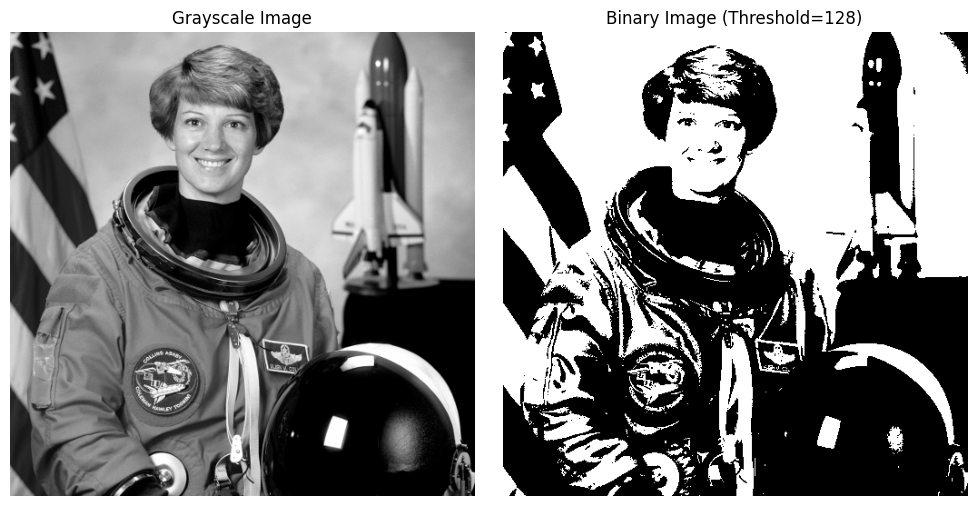

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color

# Load a sample grayscale image (camera image from skimage)
image = color.rgb2gray(data.astronaut())

# Convert to 8-bit grayscale for thresholding
image_uint8 = (255 * image).astype(np.uint8)

# Apply thresholding at value 128
threshold = 128
binary_image = (image_uint8 >= threshold).astype(np.uint8)

# Plot the original grayscale and binary version
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image_uint8, cmap='gray')
axes[0].set_title("Grayscale Image")
axes[0].axis('off')

axes[1].imshow(binary_image, cmap='gray')
axes[1].set_title("Binary Image (Threshold=128)")
axes[1].axis('off')

plt.tight_layout()
plt.show()


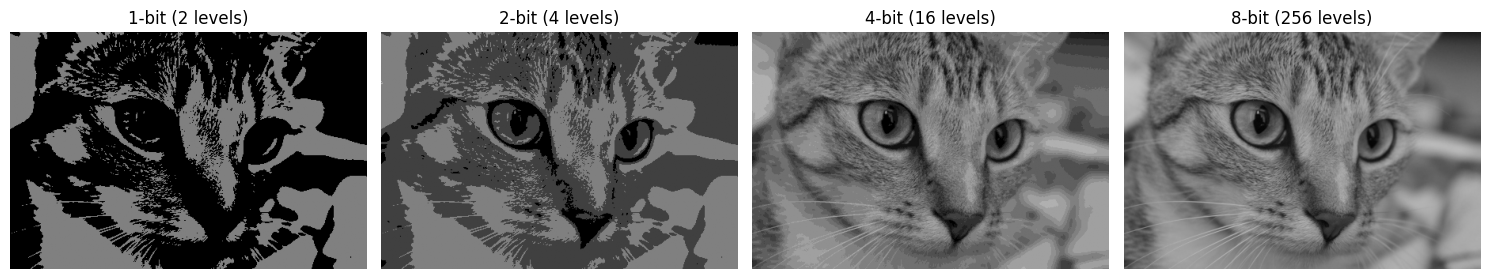

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color

# Load sample grayscale image
image = color.rgb2gray(data.chelsea())  # returns float in [0,1]
image_uint8 = (255 * image).astype(np.uint8)  # scale to 8-bit

# Function to quantize image to k-bit grayscale
def quantize_bits(img, k):
    levels = 2**k
    # scale to levels and back to 0-255
    quantized = np.floor(img / (256 / levels)) * (256 / levels)
    return quantized.astype(np.uint8)

# Bit depths to show
bit_depths = [1, 2, 4, 8]
quantized_images = [quantize_bits(image_uint8, k) for k in bit_depths]

# Plot
fig, axes = plt.subplots(1, len(bit_depths), figsize=(15, 5))
for ax, img, k in zip(axes, quantized_images, bit_depths):
    ax.imshow(img, cmap='gray', vmin=0, vmax=255)
    ax.set_title(f"{k}-bit ({2**k} levels)")
    ax.axis('off')

plt.tight_layout()
plt.show()


(np.float64(-0.5), np.float64(450.5), np.float64(299.5), np.float64(-0.5))

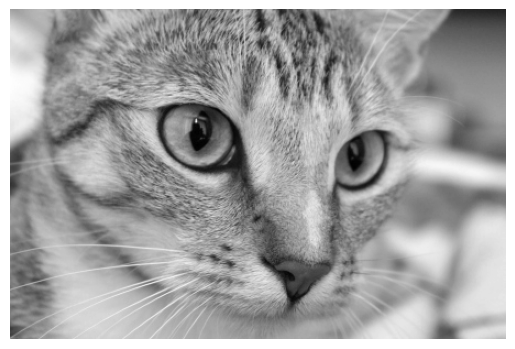

In [19]:
plt.imshow(img, cmap='gray')
plt.axis('off')

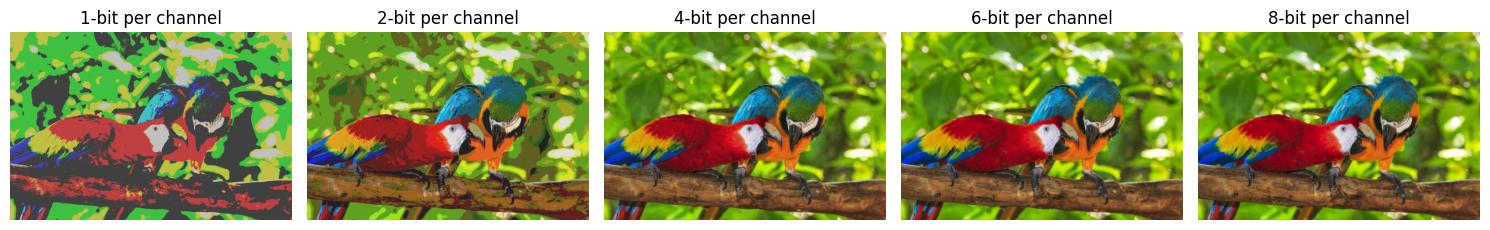

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a sample image (replace with your own if needed)
# OpenCV loads images in BGR, so we convert to RGB for matplotlib
path = '/content/drive/MyDrive/up cebu/csmc 178IP/data/parrots-large.jpg'
img = cv2.imread(cv2.samples.findFile(path))
if img is None:
    raise FileNotFoundError("Sample image not found. Replace with your own image path.")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def quantize_color(img, k):
    """
    Quantize a color image to k bits per channel.
    Each channel has values mapped to 2^k discrete levels.
    """
    levels = 2 ** k
    step = 256 // levels
    quantized = (img // step) * step + step // 2
    return np.clip(quantized, 0, 255).astype(np.uint8)

# Define bit levels to test
k_values = [1, 2, 4, 6, 8]

# Plot results
plt.figure(figsize=(15, 6))

for i, k in enumerate(k_values, 1):
    q_img = quantize_color(img, k)
    plt.subplot(1, len(k_values), i)
    plt.imshow(q_img)
    plt.title(f"{k}-bit per channel")
    plt.axis("off")

plt.tight_layout()
plt.show()

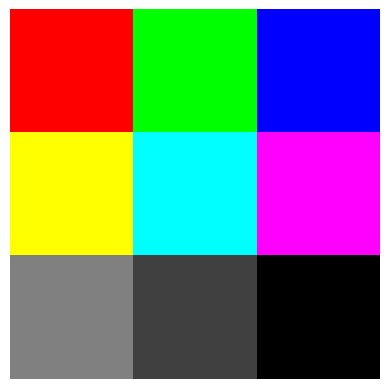

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 3x3 pixel RGB image (values in 0-255)
rgb_array = np.array([
    [[255, 0, 0],   [0, 255, 0],   [0, 0, 255]],     # Red, Green, Blue
    [[255, 255, 0], [0, 255, 255], [255, 0, 255]],   # Yellow, Cyan, Magenta
    [[128, 128, 128], [64, 64, 64], [0, 0, 0]]       # Gray, Dark Gray, Black
], dtype=np.uint8)

plt.imshow(rgb_array)
plt.axis("off")
plt.show()
